# Анализ световой кривой PKS1510-089

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

input_file = 't_min_t_max_flux_fluxerror_index_indexerror.txt'

# plotting params
plt.rcParams["figure.figsize"] =(7,7)
plt.rcParams.update({'font.size': 14})

## Чтение и подготовка данных

In [93]:
data = pd.read_csv(input_file, header=None, sep=' ')
data.columns = ['tmin', 'tmax', 'flux', 'flux_err', 'index', 'index_err']

missing_index_error = data['index_err'].max()
data.fillna(value={'index_err':missing_index_error}, inplace=True)

data.head()

,tmin,tmax,flux,flux_err,index,index_err
0,239557400.0,239989400.0,7.131599e-08,4.613111e-08,-2.391526,0.479762
1,239989400.0,240421400.0,1.253464e-07,4.947850e-08,-2.238380,0.272165
2,240421400.0,240853400.0,3.065586e-07,6.080864e-08,-2.335892,0.164535
3,240853400.0,241285400.0,4.959909e-07,7.114100e-08,-2.571239,0.148514
4,241285400.0,241717400.0,4.668069e-07,6.339139e-08,-2.297302,0.114317


Конвертация MET в актуальные времена в формате `pandas.Timestamp` — для информации и может быть полезно на будущее

In [94]:
# see https://fermi.gsfc.nasa.gov/ssc/data/analysis/documentation/Cicerone/Cicerone.pdf
MET_REFERENCE_DATE = pd.Timestamp('January 1, 2001, 0:0:0')

def fermi_met_to_utc(met) -> pd.Timestamp:
    return MET_REFERENCE_DATE + pd.Timedelta(met, unit='s')

print(f"lightcurve full interval: from {fermi_met_to_utc(data.iloc[0, 0])} to {fermi_met_to_utc(data.iloc[-1, 1])}")


lightcurve full interval: from 2008-08-04 15:43:20 to 2018-03-15 15:43:20


## Визуализация

In [95]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Source: https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html

    Modified to use median and variation from median instead of mean and std

    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    # cov = np.cov(x, y)
    cov_X =  np.mean((x - np.median(x))**2)
    cov_Y =  np.mean((y - np.median(y))**2)
    cov_XY = np.mean(
        (x - np.median(x))*(y - np.median(y))
    )

    pearson = cov_XY/np.sqrt(cov_X * cov_Y)
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov_X) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y...
    scale_y = np.sqrt(cov_Y) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

Двумерное распределение потока и индекса с эллипсом, показывающем область 2$\sigma$-отклонения от **медианы** (не среднего!)

В линейном масштабе:

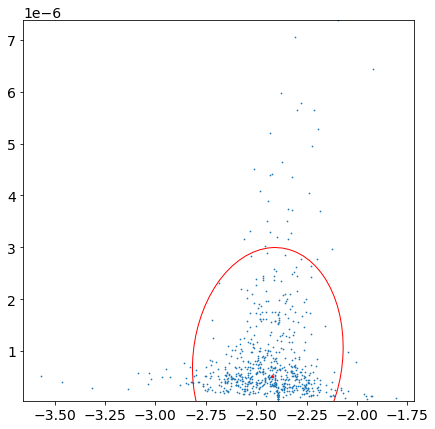

In [96]:
ax = plt.axes()
# plt.yscale('log')
ax.set_ylim(data['flux'].min(), data['flux'].max())

ax.scatter(data['index'], data['flux'], s=0.5)
confidence_ellipse(
    data['index'].to_numpy(), data['flux'].to_numpy(), ax, n_std=2.0, edgecolor='red'
)

ax.scatter(data['index'].median(), data['flux'].median(), c='red', s=3)

plt.savefig('selection_ellipse.png')
plt.show()

В логарифмическом:

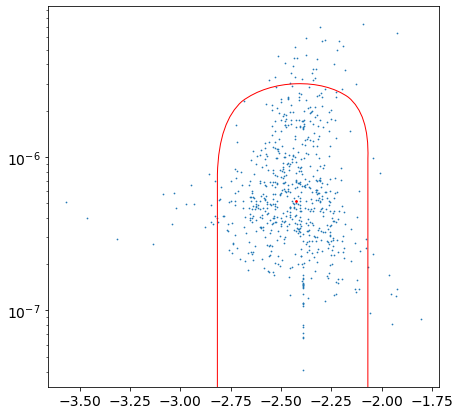

In [97]:
ax = plt.axes()
plt.yscale('log')

ax.scatter(data['index'], data['flux'], s=0.5)
confidence_ellipse(
    data['index'].to_numpy(), data['flux'].to_numpy(), ax, n_std=2.0, edgecolor='red'
)

ax.scatter(data['index'].median(), data['flux'].median(), c='red', s=3)

plt.savefig('selection_ellipse.png')
plt.show()

Наконец, 2D-гистограмма:

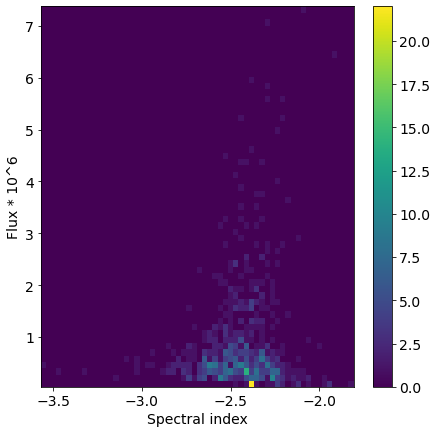

In [98]:
plt.hist2d(data['index'], data['flux']*1e6, bins=60)
plt.colorbar()
plt.ylabel('Flux * 10^6')
plt.xlabel('Spectral index')
plt.show()

## Критерий отбора состояний low-state

В текущей версии high-state-точки определяются как выбросы из нормального распрделения, фитирующего форму эмпирической плотности распределения в области низких потоков. Считаем, что основной пик на гистограмме соответствует low-state, фитируем его гауссианой, ставим $3\sigma$ (или другое количество сигм!) границу.

На самом деле стоит отметить, что никакого нормального распределения там быть в принципе не может. Если аккуратно посмотреть математику, то с учётом эффектов установки там должно быть что-то типа гамма-распределения. Поэтому гауссиана здесь — исключительно трюк обработки, призванный выделить «основной пик». Возможно, это не лучший способ, стоит подумать ещё.

In [99]:
from scipy.optimize import curve_fit
from math import pi

n_bins = 100 # 50-200 works fine
n_sigma_threshold = 3 # more or less arbitrary

In [100]:
def gaussian(x, x0, sigma):
    return (1/(sigma*np.sqrt(2*pi))) * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def gauss_fit(x, y):
    mean_estimate = sum(x * y) / sum(y)
    sigma_estimate = np.sqrt(sum(y * (x - mean_estimate) ** 2) / sum(y))
    popt, pcov = curve_fit(gaussian, x, y, p0=[mean_estimate, sigma_estimate])
    return popt

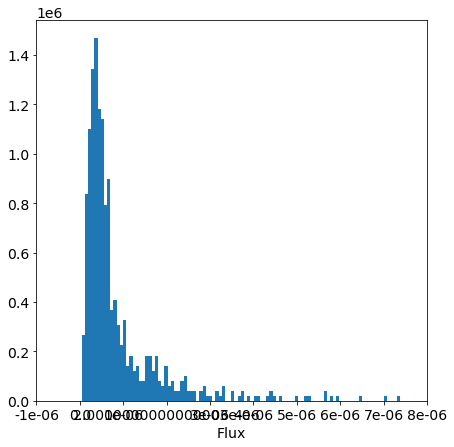

In [101]:
n, bins, _ = plt.hist(
    data['flux'], n_bins, density=True
)

locs, _ = plt.xticks()
labels = [str(loc) for loc in locs]
plt.xticks(locs, labels)

plt.xlabel('Flux')
# plt.savefig('flux_hist.png')
plt.show()

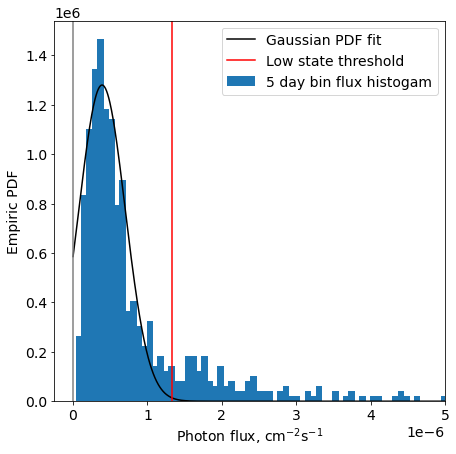

In [134]:
bincenters = (bins[:-1] + bins[1:]) / 2
x0, sigma = gauss_fit(bincenters, n)
flux_threshold = x0 + n_sigma_threshold*sigma

# plt.plot(bincenters, n, 'b.', label='5 day bin flux histogam')
plt.bar(bincenters, n, width=1.2*(bincenters[1]-bincenters[0]), label='5 day bin flux histogam')

locs = np.linspace(0, 9e-6, 10)
plt.xticks(locs)

pdf_x = np.linspace(0, bins[-1], 1000)
pdf_y = gaussian(pdf_x, x0, sigma)
plt.plot(pdf_x, pdf_y, '-k', label='Gaussian PDF fit')

ax = plt.gca()
ax.axvline(x=flux_threshold, color='r', label='Low state threshold')
ax.axvline(color='grey')

plt.xlim([-0.25e-6, 5e-6])
plt.xlabel('Photon flux, cm$^{-2}$s$^{-1}$')
plt.ylabel('Empiric PDF')
plt.legend()
plt.savefig('lowstate_selection_3.pdf')

Наконец, график, аналогичный Fig. 2 в Acciari18a (гистограмма логарифма потока) — для сравнения.

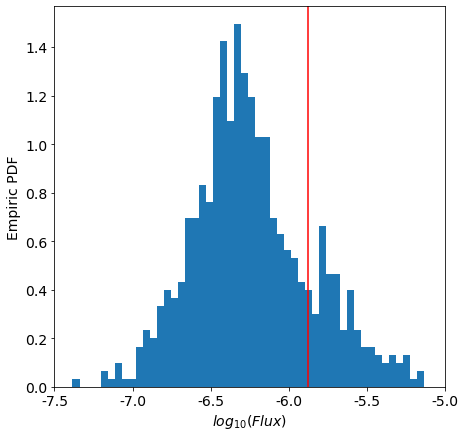

In [127]:
plt.hist(np.log10(data['flux']), 50, density=True)

locs, _ = plt.xticks()
labels = [str(loc) for loc in locs]
plt.xticks(locs, labels)

plt.xlabel('$log_{10}(Flux)$')
plt.ylabel('Empiric PDF')
ax = plt.gca()
ax.axvline(x=np.log10(flux_threshold), color='r')
plt.show()
# plt.savefig("lowstate_selection.pdf")

Визуализируем маску, полученную из порога по потоку, пока без сглаживания

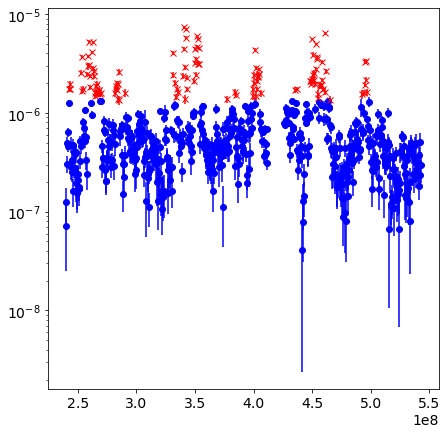

In [128]:
lowstate_mask = np.less(data['flux'].to_numpy(), flux_threshold)

t = (data['tmin'].to_numpy() + data['tmax'].to_numpy()) / 2

plt.errorbar(t[lowstate_mask],
             data.loc[lowstate_mask, 'flux'],
             data.loc[lowstate_mask, 'flux_err'],
             fmt='bo')
plt.errorbar(t[~lowstate_mask],
             data.loc[~lowstate_mask, 'flux'],
             data.loc[~lowstate_mask, 'flux_err'],
             fmt='rx')

plt.yscale('log')
plt.show()

И со сглаживанием скользящим средним, чтобы не учитывать возможные краткосрочные превышения (или наоборот понижения на фоне high-state) порога, а включать только «систематические», не объясняемые статистическими флуктуациями. Чтобы отключить сглаживание, достаточно указать `moving_average_order=1`

In [129]:
moving_average_order = 3 # бин

def moving_average(a):
    n = moving_average_order
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

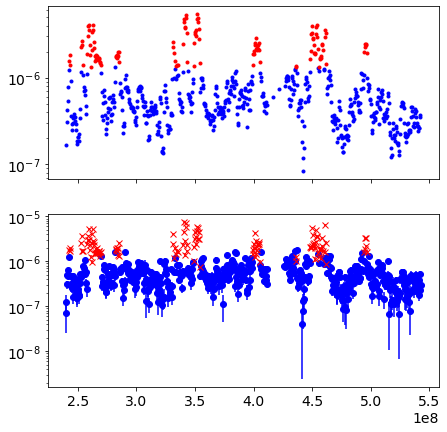

In [130]:
from scipy.interpolate import interp1d

t = (data['tmin'].to_numpy() + data['tmax'].to_numpy()) / 2
signal = data['flux'].to_numpy()
signal_err = data['flux_err'].to_numpy()

indicator_t = moving_average(t)
indicator_sgn = moving_average(signal)
lowstate_indicator_mask = np.less(indicator_sgn, flux_threshold)

lowstate_mask = interp1d(
    indicator_t, lowstate_indicator_mask,
    kind='linear', bounds_error=False, fill_value=True
)(t).astype('bool')

_, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.errorbar(indicator_t[lowstate_indicator_mask],
             indicator_sgn[lowstate_indicator_mask],
             fmt='b.')
ax1.errorbar(indicator_t[~lowstate_indicator_mask],
             indicator_sgn[~lowstate_indicator_mask],
             fmt='r.')
ax1.set_yscale('log')

ax2.errorbar(t[lowstate_mask],
             signal[lowstate_mask],
             signal_err[lowstate_mask],
             fmt='bo')
ax2.errorbar(t[~lowstate_mask],
             signal[~lowstate_mask],
             signal_err[~lowstate_mask],
             fmt='rx')
ax2.set_yscale('log')

plt.show()

## Конвертирование и сохранения

Раздел выше можно заменить на любой другой, и с помощью кода ниже сконвертировать бинарную маску, которую легко получать из порогов и других фильтрующих условий, в набор MET интервалов.

In [131]:
def intervals_from_mask(mask, polarity=True):
    """
    Convert bool mask to slices with given polarity

    Ex.: [0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1] -> [(3,6), (8,9), (11,13)]

    Resulting tuples are ready for slicing, i.e.
    for i, j in intervals_from_mask(mask):
        assert mask[i:j].all() == True
    """
    if len(mask)==0:
        return []
    if mask[0]==polarity:
        start_idx = 0
    else:
        start_idx = 1
    intervalends = np.nonzero(np.diff(mask) == True)[0]
    intervalends = [-1] + list(intervalends) + [len(mask)-1]
    return [
        (intervalends[i]+1, intervalends[i+1]+1)
        for i in range(start_idx, len(intervalends)-1, 2)
    ]

In [228]:
lowstate_idx = intervals_from_mask(lowstate_mask, polarity=True)

with open('lowstate_MET_times.txt', 'w') as f:
    for idx in lowstate_idx:
        f.write('{}\t{}\n'.format(t[idx[0]], t[idx[1]-1]))